In [215]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [217]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

In [218]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.BatchNorm2d, nn.ConvTranspose2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.2)

In [219]:
EPOCHS = 10
IMG_CHANNELS =  3
BATCH_SIZE = 64
IMG_SIZE = 64
Z_DIM = 100
FEATURES_G = 64
FEATURES_D = 64
LEARNING_RATE = 5e-5
WEIGHT_CLIP = 0.01
CRITIC_ITERATIONS = 5

In [220]:
with torch.device(DEVICE):

  gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G)
  critic = Critic(IMG_CHANNELS, FEATURES_D)

  initialize_weights(gen)
  initialize_weights(critic)

In [221]:
critic_opt = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)
gen_opt = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)

In [222]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)])
])

In [223]:
dataset = datasets.ImageFolder(root='celeb_dataset/', transform=transform)

indices = torch.randperm(len(dataset))[:10_048]
data = Subset(indices=indices, dataset=dataset)

loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


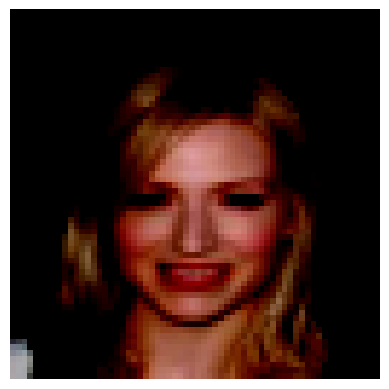

In [224]:
import matplotlib.pyplot as plt
import numpy as np

rand_idx = np.random.randint(low=0, high=len(dataset))
img = dataset[rand_idx][0].permute(1, 2, 0)
plt.imshow(img)
plt.axis(False)
plt.show()

In [249]:
writer_real = SummaryWriter('logs/WGANs/Real')
writer_fake = SummaryWriter('logs/WGANs/Fake')
step = 0

In [226]:
from tqdm import tqdm

for epoch in range(EPOCHS):
  for batch_idx, (real, _) in enumerate(tqdm(loader)):
    real = real.to(DEVICE)
    cur_batch_size = real.shape[0]

    for _ in range(CRITIC_ITERATIONS):
      noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      critic_opt.step()

      for p in critic.parameters():
        p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)


    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    gen_opt.step()

    if batch_idx == ((len(data)/BATCH_SIZE) - 1):
      gen.eval()
      critic.eval()
      print(f"\nEpoch [{epoch}/{EPOCHS}], Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")

      with torch.no_grad():
        fake = gen(noise)
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1
        gen.train()
        critic.train()

100%|████████████████████| 157/157 [00:45<00:00,  3.43it/s]



Epoch [0/10], Loss D: -1.4407, loss G: 0.7116


100%|████████████████████| 157/157 [00:40<00:00,  3.86it/s]



Epoch [1/10], Loss D: -1.4829, loss G: 0.7291


100%|████████████████████| 157/157 [00:40<00:00,  3.85it/s]



Epoch [2/10], Loss D: -1.4789, loss G: 0.7220


100%|████████████████████| 157/157 [00:40<00:00,  3.86it/s]



Epoch [3/10], Loss D: -1.4779, loss G: 0.7226


100%|████████████████████| 157/157 [00:40<00:00,  3.85it/s]



Epoch [4/10], Loss D: -1.4842, loss G: 0.7236


100%|████████████████████| 157/157 [00:40<00:00,  3.87it/s]



Epoch [5/10], Loss D: -1.4767, loss G: 0.7167


100%|████████████████████| 157/157 [00:39<00:00,  3.93it/s]



Epoch [6/10], Loss D: -1.4691, loss G: 0.7092


100%|████████████████████| 157/157 [00:39<00:00,  3.95it/s]



Epoch [7/10], Loss D: -1.4701, loss G: 0.7061


100%|████████████████████| 157/157 [00:39<00:00,  3.97it/s]



Epoch [8/10], Loss D: -1.4673, loss G: 0.7004


100%|████████████████████| 157/157 [00:39<00:00,  3.95it/s]


Epoch [9/10], Loss D: -1.4712, loss G: 0.6957


In [243]:
def gradient_penalty(critic, real, fake, device='cpu'):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated = real * epsilon + fake * (1 - epsilon)

  mixed_scores = critic(interpolated)

  gradient = torch.autograd.grad(
      inputs=interpolated,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty

In [250]:
with torch.device(DEVICE):

  gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G)
  critic = Critic(IMG_CHANNELS, FEATURES_D)

  initialize_weights(gen)
  initialize_weights(critic)

In [251]:
EPOCHS = 10
IMG_CHANNELS =  3
BATCH_SIZE = 64
IMG_SIZE = 64
Z_DIM = 100
FEATURES_G = 64
FEATURES_D = 64
LEARNING_RATE = 1e-4
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [252]:
critic_opt = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0, 0.9))
gen_opt = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 0.9))

In [253]:
for epoch in range(EPOCHS):
  for batch_idx, (real, _) in enumerate(tqdm(loader)):
    real = real.to(DEVICE)
    cur_batch_size = real.shape[0]

    for _ in range(CRITIC_ITERATIONS):
      noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      gp = gradient_penalty(critic, real, fake, DEVICE)
      loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + (LAMBDA_GP * gp)

      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      critic_opt.step()


    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    gen_opt.step()

    if batch_idx == ((len(data)/BATCH_SIZE) - 1):
      gen.eval()
      critic.eval()
      print(f"\nEpoch [{epoch}/{EPOCHS}], Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")

      with torch.no_grad():
        fake = gen(noise)
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1
        gen.train()
        critic.train()

100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [0/10], Loss D: 6.1729, loss G: 12.0462


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [1/10], Loss D: -5.7546, loss G: 11.0418


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [2/10], Loss D: -17.5905, loss G: 28.4582


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [3/10], Loss D: -17.2212, loss G: 37.0479


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [4/10], Loss D: -11.7440, loss G: 34.9101


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [5/10], Loss D: -12.2496, loss G: 35.3180


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [6/10], Loss D: -10.4447, loss G: 33.8651


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [7/10], Loss D: -10.6921, loss G: 33.2736


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch [8/10], Loss D: -10.9181, loss G: 36.7675


100%|████████████████████| 157/157 [01:08<00:00,  2.30it/s]


Epoch [9/10], Loss D: -10.2622, loss G: 41.0620
